In [1]:
import h5py, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm
from ipywidgets import interact, IntSlider, Dropdown
import json
import pandas as pd
from matplotlib.patches import Rectangle

h5_path = "/kaggle/input/rsna-patches/patches_16levels.h5"
slices_meta = "/kaggle/input/meta-slice/aneurysm_slices_with_z.csv"
full_h5_path = "/kaggle/input/rsna-dataset/dataset.h5"


PATCH_SHAPE = (64, 64, 64)
BOX_SIZE = 16  # cadre 16×16


In [2]:
def unpack_4bit(arr):
    arr = np.asarray(arr, dtype=np.uint8)
    hi, lo = arr >> 4, arr & 0x0F
    return np.stack((hi, lo), axis=-1).ravel()

def unpack_4bit_nlevels(arr):
    arr = np.frombuffer(arr, dtype=np.uint8)
    hi = arr >> 4
    lo = arr & 0x0F
    uniq_hi = np.unique(hi)
    uniq_lo = np.unique(lo)
    # union des deux moitiés
    return len(np.unique(np.concatenate([uniq_hi, uniq_lo])))


In [3]:
def patch_to_uid(k):
    with h5py.File(h5_path, "r") as f:
        meta = json.loads(bytes(f["meta"][:]).decode("utf-8"))
    uid, z, y, x, label = meta[k]
    return uid

def show_patch_by_index(k):
    with h5py.File(h5_path, "r") as f:
        # Charger les métadonnées
        meta = json.loads(bytes(f["meta"][:]).decode("utf-8"))
        uid, z0, y0, x0, label = meta[k]
        flat = f["X"][k]
        yk = int(f["y"][k])

    print(f"Patch index={k}")
    print(f"SOPInstanceUID={uid}")
    print(f"z={z0}, y={y0}, x={x0}, label={label}, y={yk}")

    vals = unpack_4bit(flat)[: np.prod(PATCH_SHAPE)]
    patch = vals.reshape(PATCH_SHAPE)

    def view_slice(z=0):
        plt.figure(figsize=(4, 4))
        plt.imshow(patch[z], cmap="gray", vmin=0, vmax=15)
        plt.title(f"Patch {k} | Slice {z} — y={yk}")
        plt.axis("off")
        plt.show()

    interact(view_slice, z=IntSlider(min=0, max=PATCH_SHAPE[0] - 1, step=1, value=PATCH_SHAPE[0] // 2))
    return uid, z0, y0, x0

In [4]:
def show_series_by_uid(uid, x0, y0, z0):
    with h5py.File(full_h5_path, "r") as f:
        meta_all = f["meta"][()]
        found = None
        for i, m in enumerate(meta_all):
            if isinstance(m[-1], (bytes, np.bytes_)) and m[-1].decode(errors="ignore") == uid:
                found = i
                break
        if found is None:
            raise KeyError(f"UID {uid} non trouvé dans meta")

        vol = f["X"][str(found)][()]
        label = int(f["y"][found])

    print(f"Série trouvée : index={found} | UID={uid} | shape={vol.shape} | label={label}")


    def view_slice(z):
        plt.figure(figsize=(5, 5))
        plt.imshow(vol[z], cmap="gray")

        # Si le plan z intersecte le patch → tracer un rectangle
        if z0 <= z < z0 + PATCH_SHAPE[0]:
            rect = Rectangle(
                (x0, y0),
                PATCH_SHAPE[2],  # largeur
                PATCH_SHAPE[1],  # hauteur
                linewidth=2, edgecolor="r", facecolor="none"
            )
            plt.gca().add_patch(rect)

        plt.title(f"UID {uid} — slice {z}/{vol.shape[0]-1}")
        plt.axis("off")
        plt.show()

    interact(view_slice, z=IntSlider(min=0, max=vol.shape[0]-1, step=1, value=z0 + PATCH_SHAPE[0]//2))

In [5]:
uid = patch_to_uid(245553)
print(uid)
uid, z0, y0, x0 = show_patch_by_index(245553)
show_series_by_uid(uid, x0, y0, z0)

1.2.826.0.1.3680043.8.498.13078986446804909952913728407056713347
Patch index=245553
SOPInstanceUID=1.2.826.0.1.3680043.8.498.13078986446804909952913728407056713347
z=128, y=448, x=256, label=0, y=0


interactive(children=(IntSlider(value=32, description='z', max=63), Output()), _dom_classes=('widget-interact'…

Série trouvée : index=1106 | UID=1.2.826.0.1.3680043.8.498.13078986446804909952913728407056713347 | shape=(243, 512, 512) | label=0


interactive(children=(IntSlider(value=160, description='z', max=242), Output()), _dom_classes=('widget-interac…

[INFO] 970,975 patches détectés


Analyse par blocs: 100%|██████████| 475/475 [1:19:28<00:00, 10.04s/bloc]


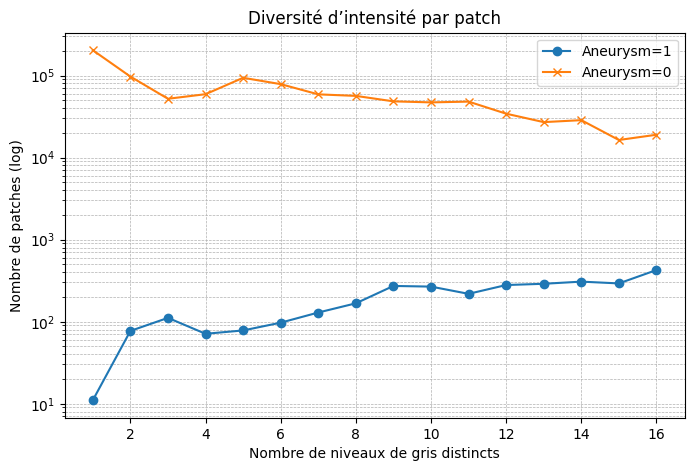

In [28]:
BATCH = 2048  # taille de bloc : ajuste selon la RAM disponible

def count_levels_batch(batch):
    """Retourne le nombre de niveaux distincts (0–15) pour chaque patch du bloc."""
    hi = batch >> 4
    lo = batch & 0x0F
    vals = np.concatenate([hi[..., None], lo[..., None]], axis=-1).reshape(len(batch), -1)
    # nombre de valeurs distinctes par patch
    return np.apply_along_axis(lambda v: len(np.unique(v)), 1, vals)

counts = defaultdict(int)

with h5py.File(h5_path, "r") as f:
    X = f["X"]
    y = np.array(f["y"], dtype=np.uint8)
    total = len(X)
    print(f"[INFO] {total:,} patches détectés")

    for start in tqdm(range(0, total, BATCH), desc="Analyse par blocs", unit="bloc"):
        end = min(start + BATCH, total)
        batch = np.array(X[start:end], dtype=np.uint8)
        nlv = count_levels_batch(batch)
        for l, label in zip(nlv, y[start:end]):
            counts[(l, int(label))] += 1

levels_unique = sorted({l for l, _ in counts})
counts_pos = [counts[(l, 1)] for l in levels_unique]
counts_neg = [counts[(l, 0)] for l in levels_unique]

plt.figure(figsize=(8, 5))
plt.plot(levels_unique, counts_pos, label="Aneurysm=1", marker="o")
plt.plot(levels_unique, counts_neg, label="Aneurysm=0", marker="x")
plt.yscale("log")
plt.xlabel("Nombre de niveaux de gris distincts")
plt.ylabel("Nombre de patches (log)")
plt.title("Diversité d’intensité par patch")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)

plt.show()

In [6]:
import random
def random_positive_patch():
    with h5py.File(h5_path, "r") as f:
        y = np.array(f["y"])
        meta = json.loads(bytes(f["meta"][:]).decode("utf-8"))
    pos_idx = np.where(y == 1)[0]
    k = int(random.choice(pos_idx))
    uid, z, y0, x0, label = meta[k]
    return k, uid, z, y0, x0

In [7]:
def show_patch(k):
    with h5py.File(h5_path, "r") as f:
        meta = json.loads(bytes(f["meta"][:]).decode("utf-8"))
        uid, z0, y0, x0, label = meta[k]
        flat = f["X"][k]
        yk = int(f["y"][k])
    vals = unpack_4bit(flat)[: np.prod(PATCH_SHAPE)]
    patch = vals.reshape(PATCH_SHAPE)

    df = pd.read_csv(slices_meta)
    row = df[df["series_uid"] == uid].sample(1).iloc[0]
    z_a, y_a, x_a = int(row["slice_index"]), int(row["y"]), int(row["x"])

    z_rel = z_a - z0
    y_rel = y_a - y0
    x_rel = x_a - x0

    z_init = int(np.clip(z_rel, 0, PATCH_SHAPE[0]-1))

    def view_slice(z=0):
        plt.figure(figsize=(4, 4))
        plt.imshow(patch[z], cmap="gray", vmin=0, vmax=15)

        if z == z_rel and 0 <= x_rel < PATCH_SHAPE[2] and 0 <= y_rel < PATCH_SHAPE[1]:
            plt.gca().add_patch(Rectangle(
                (x_rel - BOX_SIZE//2, y_rel - BOX_SIZE//2),
                BOX_SIZE, BOX_SIZE,
                linewidth=2, edgecolor="lime", facecolor="none"
            ))

        plt.title(f"Patch {k} | Slice {z} | y={yk}")
        plt.axis("off")
        plt.show()

    interact(view_slice, z=IntSlider(min=0, max=PATCH_SHAPE[0]-1, step=1, value=z_init))
    return uid, z0, y0, x0


def show_series_with_boxes(uid, x0, y0, z0, box_size=BOX_SIZE):
    df = pd.read_csv(slices_meta)
    row = df[df["series_uid"] == uid].sample(1).iloc[0]
    z_a, y_a, x_a = int(row["slice_index"]), int(row["y"]), int(row["x"])

    with h5py.File(full_h5_path, "r") as f:
        meta_all = f["meta"]
        found = None
        for i in range(len(meta_all)):
            uid_i = meta_all[i]["series_uid"]
            if isinstance(uid_i, (bytes, np.bytes_)):
                uid_i = uid_i.decode(errors="ignore")
            if uid_i == uid:
                found = i
                break
        if found is None:
            raise KeyError(f"UID {uid} non trouvé dans meta")

        vol = f["X"][str(found)][()]
        label = int(f["y"][found])

    def view_slice(z):
        plt.figure(figsize=(6, 6))
        plt.imshow(vol[z], cmap="gray", vmin=0, vmax=15)

        if z0 <= z < z0 + PATCH_SHAPE[0]:
            plt.gca().add_patch(Rectangle(
                (x0, y0), PATCH_SHAPE[2], PATCH_SHAPE[1],
                linewidth=2, edgecolor="r", facecolor="none"
            ))

        if z == z_a:
            plt.gca().add_patch(Rectangle(
                (x_a - box_size//2, y_a - box_size//2),
                box_size, box_size,
                linewidth=2, edgecolor="lime", facecolor="none"
            ))

        plt.title(f"UID {uid} | slice {z} | label={label}")
        plt.axis("off")
        plt.show()

    interact(view_slice, z=IntSlider(min=0, max=vol.shape[0]-1, step=1, value=z_a))

In [19]:
k, uid, z0, y0, x0 = random_positive_patch()
print(f"Patch positif choisi : index={k} | UID={uid}")
uid, z0, y0, x0 = show_patch(k)
show_series_with_boxes(uid, x0, y0, z0)

Patch positif choisi : index=297214 | UID=1.2.826.0.1.3680043.8.498.15847980512533357707448321523314296455


interactive(children=(IntSlider(value=34, description='z', max=63), Output()), _dom_classes=('widget-interact'…

interactive(children=(IntSlider(value=98, description='z', max=237), Output()), _dom_classes=('widget-interact…

In [14]:
import h5py, json, numpy as np, matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

full_h5_path = "/kaggle/input/rsna-dataset/dataset.h5"

def load_volume(uid):
    with h5py.File(full_h5_path, "r") as f:
        for i, m in enumerate(f["meta"]):
            uid_i = m[-1]
            if isinstance(uid_i, (bytes, np.bytes_)):
                uid_i = uid_i.decode(errors="ignore")
            if uid_i == uid:
                return f["X"][str(i)][()]
    raise KeyError(f"UID {uid} non trouvé")

def show_slice_with_grid(uid, slice_index, patch_size=64):
    vol = load_volume(uid)
    img = vol[slice_index]

    h, w = img.shape
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap="gray", vmin=0, vmax=15)

    # tracer les cadres rouges
    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            rect = Rectangle(
                (x, y),
                patch_size, patch_size,
                linewidth=1, edgecolor="r", facecolor="none"
            )
            plt.gca().add_patch(rect)

    plt.title(f"{uid} — slice {slice_index}")
    plt.axis("off")
    plt.show()


In [16]:
patch_to_uid(4523)

'1.2.826.0.1.3680043.8.498.10042474696169267476037627878420766468'

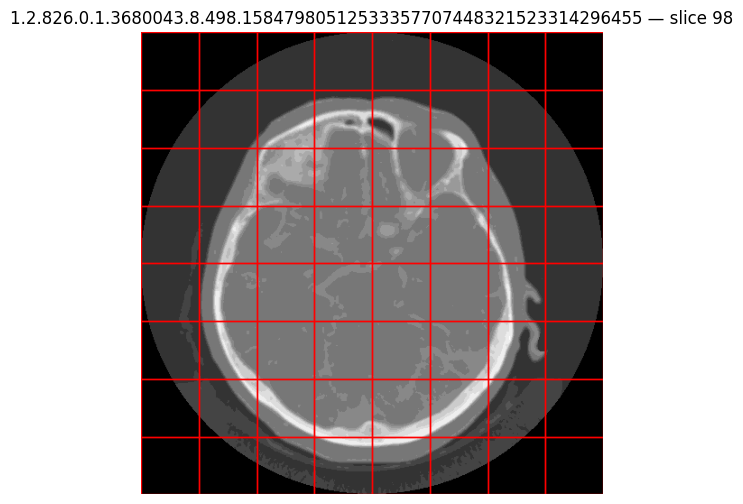

In [21]:

uid_ex = "1.2.826.0.1.3680043.8.498.15847980512533357707448321523314296455"
show_slice_with_grid(uid_ex, slice_index=98)
